# 基于深度学习的验证码破解、对抗与反对抗研究

## 概述
在信息安全领域，由于身份鉴别和防止计算机自动攻击的需要，促使了验证码技术的诞生，并伴随着验证码技术对抗的此消彼涨。当前验证码的形式和样式都日益丰富，但其自身的安全性却为很多站点所忽略。本文在利用深度学习破解验证码的基础上，还进行对抗与反对抗研究，并根据实验结果提出验证码改进策略。

## 验证码诞生
yahoo 邮箱在九几年的时候，业务深受各种邮箱机器人的困扰，存在着大量的垃圾邮件，于是他们找到了当时仍在读大学的路易斯·冯·安(Luis von Ahn)，并设计了经典的图形验证码，即通过简单的扭曲图形文字进行机器的识别。

## 验证码类型
1. 图片验证码：在网页上以图片形式呈现给用户。
2. 手机验证码：用户在网页上提交自己的手机号码，系统以短信形式形式将验证码发送到用户手机上。
3. 邮件验证码：用户在网页上提交自己的电子邮箱，系统以电子邮箱形式将验证码发送到用户邮箱上。
4. ......

## 验证码沦陷
验证码的本质是要容易被正常用户解答并且让恶意用户无法解答，即将正常用户和恶意用户区分开来。然而各类验证码都已经有了相当成熟的对抗办法，更不用说现在已经泛滥的打码平台了。
1. 图片验证码：
    1. 预处理
        1. 背景色混淆 - 二值化
        2. 字体镂空 - 凸多边形填充
        3. 多字体混用 - 多字体训练
        4. 文字扭曲 - 字库
        5. 文字黏连 - 滴水法分割
        6. 干扰线 - 联通量阈值去除
        7. ....
    2. 识别
        1. 字库比较
        2. 机器学习
        3. 深度学习
2. 短信验证码：
    1. 安全性
        1. 仅从验证码的角度来说，这种方法可以较好地阻挡攻击者。
    2. 存在问题：
        1. 受移动运营商短信网关的限制，有时会导致用户无法收到短信。
        2. 可能造成对手机的 DoS 攻击。
3. 邮件验证码：
    1. 安全性
        1. 一般。
    2. 存在问题
        1. 攻击者可以编写程序从电子邮箱中获取电子邮件，对邮件分析可以取得验证码。
        2. 与手机验证码相似，可能造成对邮箱的 DoS 攻击。
    
## 验证码博弈
安全是一个博弈的过程。虽然正义力量和邪恶力量两方数量上略有差距，但是总体战斗力还算是勉强打个平手，互相出招而已。
```
程序员:熬一晚上升级
攻击者:熬一晚上破解
程序员:熬两晚上升级
攻击者:熬两晚上破解
....(心疼)...
```
只是随着战火的升级，验证码已经违背了最初设计时的初衷：对普通用户的友好性逐渐消失，普通用户的体验成了这场战争中的牺牲品，这也就造就了一批又一批被用户吐槽的面目全非的验证码。
![alt text](docs/0.jpg)

---

> 参考论文
1. 吉治钢 - 基于验证码破解的HTTP攻击原理与防范
2. 文晓阳 高能 夏鲁宁 荆继武 - 高效的验证码识别技术与验证码分类思想 

> 参考链接
1. http://www.freebuf.com/articles/network/97030.html
2. https://www.cnblogs.com/alisecurity/p/5581049.html
3. https://dev.qq.com/topic/581301b146dfb1456904df8d

## 阶段一：验证码破解

> 参考链接
1. https://github.com/ypwhs/captcha_break
2. https://keras.io/
3. https://opencv.org/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import string

# 0123456789
# ABCDEFGHIJKLMNOPQRSTUVWXYZ
characters = string.digits + string.ascii_uppercase

images = glob.glob('IMG/*.jpg')

X = []
y = []

for image in images:
    X.append(cv2.imread(image))
    y.append([characters.find(ch) for ch in image[-8:-4]])

In [2]:
image = cv2.imread(images[0])
label = images[0][-8:-4]

## 去噪方案一：形态学转换

### 开运算cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
先腐蚀再膨胀。

### 闭运算cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
先膨胀再腐蚀。

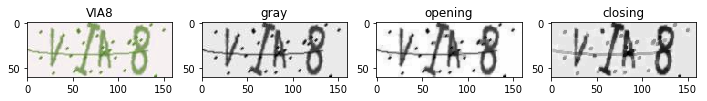

In [3]:
# 灰度化
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# 开运算=腐蚀+膨胀
opening = cv2.morphologyEx(gray, cv2.MORPH_OPEN, np.ones((3, 3)))
# 闭运算=膨胀+腐蚀
closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, np.ones((3, 3)))

plt.figure(figsize = (12, 4))
plt.subplot(1, 4, 1)
plt.imshow(image, cmap='gray')
plt.title(label)
plt.subplot(1, 4, 2)
plt.imshow(gray, cmap='gray')
plt.title('gray')
plt.subplot(1, 4, 3)
plt.imshow(opening, cmap='gray')
plt.title('opening')
plt.subplot(1, 4, 4)
plt.imshow(closing, cmap='gray')
plt.title('closing')

## 去噪方案二：二值化

### 简单阈值cv2.threshold(img,127,255,cv2.THRESH_BINARY)
像素值高于阈值时，我们给这个像素赋予一个新值（可能是白色），否则赋予另外一种颜色。
1. cv2.THRESH_BINARY：二值化阈值
2. cv2.THRESH_BINARY_INV：反转二值化阈值
3. cv2.THRESH_TRUNC：截断二值化阈值
4. cv2.THRESH_TOZERO：超过阈值被置为0
5. cv2.THRESH_TOZERO_INV：低于阈值被置为0

### 自适应阈值cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
根据图像上的每一个小区域计算与其对应的阈值，在同一幅图像上的不同区域采用的是不同的阈值。
1. cv2.ADPTIVE_THRESH_MEAN_C：阈值取自相邻区域的平均值
2. cv2.ADPTIVE_THRESH_GAUSSIAN_C：阈值取自相邻区域的加权和，权重为一个高斯窗口。

### Otsu’s 二值化cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
对一副双峰图像自动根据其直方图计算出一个阈值。

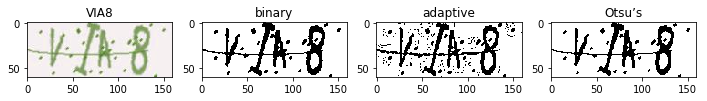

In [4]:
# 灰度化
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# 二值化
_, blur1 = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
# 自适应二值化
blur2    = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
# Otsu’s 二值化
_, blur3 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.figure(figsize = (12, 4))
plt.subplot(1, 4, 1)
plt.imshow(image, cmap='gray')
plt.title(label)
plt.subplot(1, 4, 2)
plt.imshow(blur1, cmap='gray')
plt.title('binary')
plt.subplot(1, 4, 3)
plt.imshow(blur2, cmap='gray')
plt.title('adaptive')
plt.subplot(1, 4, 4)
plt.imshow(blur3, cmap='gray')
plt.title('Otsu’s')

## 去噪方案二（接上）：滤波

### 中值滤波cv2.medianBlur(img,5)
用卷积核覆盖区域所有像素的中位数来代替中心像素的值。

### 均值滤波cv2.blur(img,(5,5))
用卷积核覆盖区域所有像素的平均数来代替中心像素的值。

### 高斯滤波cv2.GaussianBlur(img,(5,5),0)
把卷积核换成高斯核（卷积核的值符合高斯分布），原来的求平均数变成求加权平均数

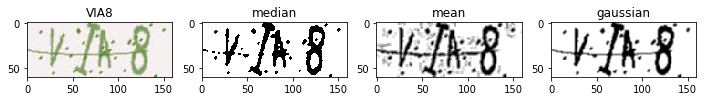

In [5]:
# 中值滤波
b1 = cv2.medianBlur(blur1, 3)
# 均值滤波
b2 = cv2.blur(blur2, (3, 3))
# 高斯滤波
b3 = cv2.GaussianBlur(blur3, (3, 3), 0)

plt.figure(figsize = (12, 4))
plt.subplot(1, 4, 1)
plt.imshow(image, cmap='gray')
plt.title(label)
plt.subplot(1, 4, 2)
plt.imshow(b1, cmap='gray')
plt.title('median')
plt.subplot(1, 4, 3)
plt.imshow(b2, cmap='gray')
plt.title('mean')
plt.subplot(1, 4, 4)
plt.imshow(b3, cmap='gray')
plt.title('gaussian')

## 分析
初步分析，“二值化+滤波”方案比“形态学转换”方案的去噪效果更好，并且能够保留验证码原貌。然而多次测试发现，由于生成的验证码变化太大，单纯的“二值化+滤波”方案并不能很好地去除噪点，强行去噪还会导致处理过的图片消失。

对于该版本的验证码本人没有研究出一种合适的方案，为了后续实验的简单，我们就不对验证码进行去噪操作。后续实验也可证明，该版本的验证码不去噪比去噪的破解率更高，然而这并不代表验证码的去噪操作无意义。

## 训练

In [6]:
from keras.models import *
from keras.layers import *

HEIGHT = 60
WIDTH = 160
n_class = len(characters)

inputs = Input((HEIGHT, WIDTH, 3))
x = inputs

for i in range(3):
    x = Conv2D(32*2**i, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
#     x = Dropout(0.1)(x)
    
    x = Conv2D(32*2**i, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
#     x = Dropout(0.1)(x)
    
    x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(200)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = Dropout(0.1)(x)

# 4个分类器
outputs = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]

model = Model(inputs=inputs, outputs=outputs)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


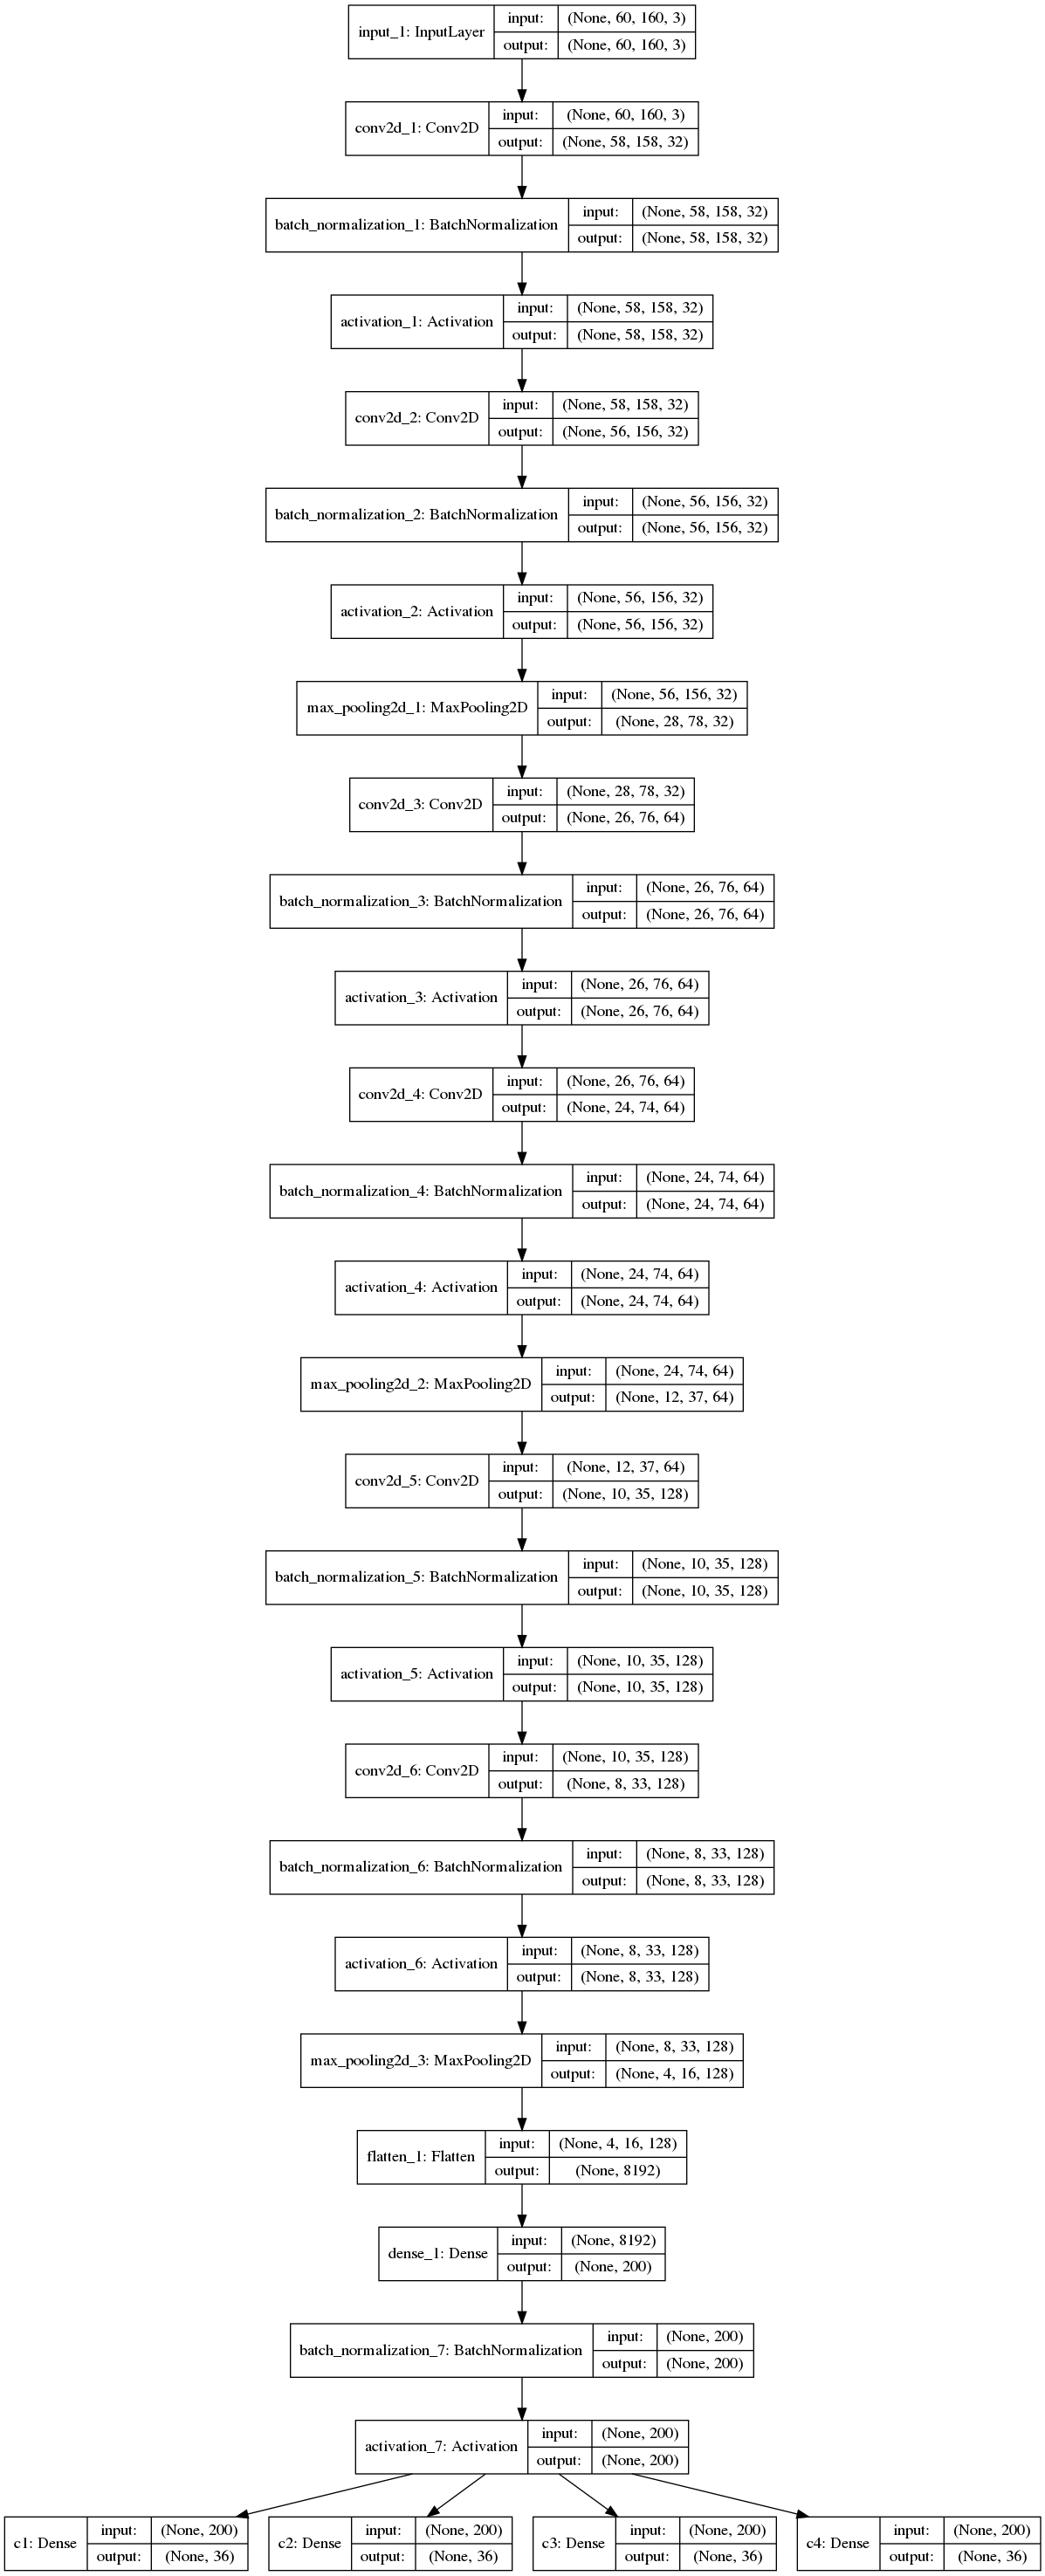

In [7]:
# 模型可视化 https://keras-cn.readthedocs.io/en/latest/other/visualization/
from keras.utils import plot_model
from IPython import display

# pip install pydot-ng
# sudo apt-get install graphviz
plot_model(model, to_file="model.png", show_shapes=True)
display.Image('model.png')

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
from keras.utils import to_categorical

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = list(to_categorical(y_train, num_classes=n_class).transpose(1, 0, 2))
y_test = list(to_categorical(y_test, num_classes=n_class).transpose(1, 0, 2))

In [10]:
from keras.callbacks import ModelCheckpoint

BATCH_SIZE = 32
EPOCHS = 20

model_checkpoint = ModelCheckpoint('model/model.h5', save_best_only=True, save_weights_only=True)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# adadelta
model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(X_test, y_test),
          shuffle=True,
          callbacks=[model_checkpoint])

Instructions for updating:
Use tf.cast instead.
Train on 15916 samples, validate on 3980 samples
Epoch 1/20
15916/15916 [==============================] - 22s 1ms/step - loss: 9.6126 - c1_loss: 2.2787 - c2_loss: 2.5897 - c3_loss: 2.5709 - c4_loss: 2.1732 - c1_acc: 0.3995 - c2_acc: 0.3050 - c3_acc: 0.3206 - c4_acc: 0.4299 - val_loss: 5.8168 - val_c1_loss: 1.1048 - val_c2_loss: 1.7669 - val_c3_loss: 1.7197 - val_c4_loss: 1.2254 - val_c1_acc: 0.6869 - val_c2_acc: 0.5015 - val_c3_acc: 0.5274 - val_c4_acc: 0.6485
Epoch 2/20
15916/15916 [==============================] - 19s 1ms/step - loss: 3.6511 - c1_loss: 0.6346 - c2_loss: 1.1740 - c3_loss: 1.1771 - c4_loss: 0.6655 - c1_acc: 0.8412 - c2_acc: 0.6748 - c3_acc: 0.6879 - c4_acc: 0.8330 - val_loss: 9.5019 - val_c1_loss: 2.3239 - val_c2_loss: 2.6438 - val_c3_loss: 2.6150 - val_c4_loss: 1.9192 - val_c1_acc: 0.3656 - val_c2_acc: 0.3098 - val_c3_acc: 0.3312 - val_c4_acc: 0.4525
Epoch 3/20
15916/15916 [==============================] - 19s 1ms/ste

Epoch 20/20
15916/15916 [==============================] - 19s 1ms/step - loss: 0.0625 - c1_loss: 0.0088 - c2_loss: 0.0200 - c3_loss: 0.0212 - c4_loss: 0.0125 - c1_acc: 0.9982 - c2_acc: 0.9945 - c3_acc: 0.9942 - c4_acc: 0.9967 - val_loss: 3.0690 - val_c1_loss: 0.4173 - val_c2_loss: 0.9433 - val_c3_loss: 1.1519 - val_c4_loss: 0.5565 - val_c1_acc: 0.8884 - val_c2_acc: 0.7894 - val_c3_acc: 0.7756 - val_c4_acc: 0.8774


## 测试

In [11]:
# 验证码识别器
def decode(y):
    acc = np.cumprod(np.max(y, axis=2)[0:])[-1]
    y = np.argmax(np.array(y), axis=2)[:,0]
    title = ''.join([characters[x] for x in y])
    return '%s %.6f' % (title, acc)

In [12]:
model.load_weights('model/model.h5')

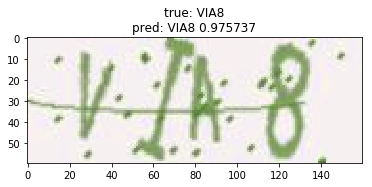

In [13]:
y_pred = model.predict(np.expand_dims(image, axis=0))
plt.imshow(image, cmap='gray')
plt.title('true: %s\npred: %s'%(label, decode(y_pred)))

## 分析
利用深度学习识别验证码可以达到80-90%的破解率，两次破解都失败的几率仅为4%-9%，这点失败率在允许错误次数面前显得微不足道。

因此，可以大胆地下结论：目前的图形验证码还不够安全。

## 对抗样本

### 什么是对抗样本
Christian Szegedy等人在ICLR2014发表的论文中，他们提出了对抗样本（Adversarial examples）的概念，即在数据集中通过故意添加细微的干扰所形成的输入样本，受干扰之后的输入导致模型以高置信度给出一个错误的输出。在他们的论文中，他们发现包括卷积神经网络（Convolutional Neural Network, CNN）在内的深度学习模型对于对抗样本都具有极高的脆弱性。他们的研究提到，很多情况下，在训练集的不同子集上训练得到的具有不同结构的模型都会对相同的对抗样本实现误分，这意味着对抗样本成为了训练算法的一个盲点。
![alt text](docs/1.png "title")

### 如何产生对抗样本
生成式对抗网络的发明人Ian Goodfellow在《Explaining and Harnessing Adversarial Examples》中提出了一种更快速方便的方法来产生对抗样本：
```
X' = X + ε⋅sign(∇xJ(Θ, x, y))
```
这种方法的思想非常简单，就是让输入图像朝着让类别置信度降低的方向上移动一个在各个维度上都是ε这么大小的一步。因为输入通常是高维的（比如224x224），再加上现在的主流神经网络结构都是ReLU系的激活函数，线性程度其实很高，所以即使是很小的ε，每个维度的效果加一块，通常也足以对结果产生很大的影响。在计算上，这种方法优势巨大，因为只需要一次前向和一次后向梯度计算就可以了。Ian Goodfellow称之为Fast Gradient Sign method。
![alt text](docs/2.png "title")

### 深度学习的脆弱性
一个推断性的解释是深度神经网络的高度非线性特征，以及纯粹的监督学习模型中不充分的模型平均和不充分的正则化所导致的过拟合。Ian Goodfellow 在ICLR2015年的论文中，通过在一个线性模型加入对抗干扰，发现只要线性模型的输入拥有足够的维度（事实上大部分情况下，模型输入的维度都比较大，因为维度过小的输入会导致模型的准确率过低），线性模型也对对抗样本表现出明显的脆弱性，这也驳斥了关于对抗样本是因为模型的高度非线性的解释。相反深度学习的对抗样本是由于模型的线性特征。

### 对抗样本的危害性
如果我们有两张图片，人眼看上去一模一样，都是一间房子，但是cnn把一张分类为房子，一张分类为鸵鸟，这种分类器还有什么用啊。如果我们的模型随随便便就被欺骗，还能被投入使用吗，那那些研究不成了纸上谈兵了吗。另一方面，有人觉得即使是Ian的方法，都需要知道梯度才能找到对抗样本，可是攻击者怎么知道模型是什么样子呢？可惜对抗样本还有一个重要性质，叫做Transferability，转移性。很多的时候，两个模型即使有不同的结构并在不同的训练集上被训练，一种模型的对抗样本在另一个模型中也同样会被误分，甚至它们还会将对抗样本误分为相同的类。这是因为对抗样本与模型的权值向量高度吻合，同时为了训练执行相同的任务，不同的模型学习了相似的函数。这种泛化特征意味着如果有人希望对模型进行恶意攻击，攻击者根本不必访问需要攻击的目标模型，就可以通过训练自己的模型来产生对抗样本，然后将这些对抗样本部署到他们需要攻击的模型中。这个可以称作灾难了，最后的堡垒也被攻破了，我们再怎么隐藏模型的细节，也可能会被攻击。

### 换个思路走的更远
正如攻击者可以利用对抗样本来攻击深度学习模型，同理我们也可以利用对抗样本来巩固自己的深度学习模型，例如前面已经被破解的验证码......

---

> 参考论文 
1. Christian Szegedy, Wojciech Zaremba, Ilya Sutskever, Joan Bruna, Dumitru Erhan, Ian Goodfellow, Rob Fergus - [Intriguing properties of neural networks](https://arxiv.org/abs/1312.6199)
2. Ian J. Goodfellow, Jonathon Shlens, Christian Szegedy - [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572)

> 参考链接
1. http://www.infoq.com/cn/news/2015/07/adversarial-examples
2. http://blog.csdn.net/cdpac/article/details/53170940
3. https://zhuanlan.zhihu.com/p/26122612

## 阶段二：验证码对抗

> 参考链接
1. https://github.com/rodgzilla/machine_learning_adversarial_examples

In [14]:
import keras.backend as K

sess = K.get_session()
epsilon = 4.0

# 生成对抗样本
def generate_adversarial(model, image):
    pred        = np.argmax(model.predict(np.array(image)), axis=2)[:, 0]
    target      = K.one_hot(pred, n_class)
    loss        = K.categorical_crossentropy(model.output, target)
    gradients   = K.gradients(loss, model.input)
    sign        = K.sign(gradients[0])
    
    noise       = epsilon * sign
    noise       = sess.run(noise, feed_dict={model.input: image})
    adversarial = np.clip(image + noise, 0., 255.).astype(np.uint8)

    return adversarial

In [15]:
adversarial = generate_adversarial(model, np.expand_dims(image, axis=0))

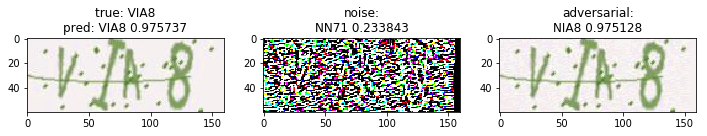

In [16]:
##### 原始样本
title_original    = 'true: %s\npred: %s' % (label, decode(model.predict(np.expand_dims(image, axis=0))))
##### 噪声
title_noise       = 'noise:\n%s' % decode(model.predict(adversarial - image))
##### 对抗样本
title_adversarial = 'adversarial:\n%s' % decode(model.predict(adversarial))
    
plt.figure(figsize = (12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title(title_original)
plt.subplot(1, 3, 2)
plt.imshow(adversarial[0] - image, cmap='gray')
plt.title(title_noise)
plt.subplot(1, 3, 3)
plt.imshow(adversarial[0], cmap='gray')
plt.title(title_adversarial)

## 反对抗样本

众所周知，在图像识别领域，对抗样本是一个非常棘手的问题，研究如何克服它们可以帮助避免潜在的危险。虽然对抗样本看似可怕，但是只要对抗样本自身发生轻微变化，对抗性质也会失灵。

> 参考链接
1. https://www.leiphone.com/news/201707/8vQdkhyfsSf0PkBP.html
2. https://www.leiphone.com/news/201707/U58CXHRIgjxDYd98.html

## 阶段三：验证码反对抗

> 参考链接
1. https://github.com/rodgzilla/machine_learning_adversarial_example

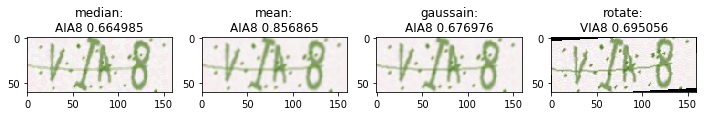

In [17]:
from PIL import Image

##### 中值滤波
img_median     = cv2.medianBlur(adversarial[0], 3)
title_median   = 'median:\n%s' % decode(model.predict(np.expand_dims(img_median, 0)))
##### 均值滤波
img_mean       = cv2.blur(adversarial[0], (3, 3))
title_mean     = 'mean:\n%s' % decode(model.predict(np.expand_dims(img_mean, 0)))
##### 高斯滤波
img_gaussain   = cv2.GaussianBlur(adversarial[0], (3, 3), 0)
title_gaussain = 'gaussain:\n%s' % decode(model.predict(np.expand_dims(img_gaussain, 0)))
##### 旋转对抗
img_rotate     = Image.fromarray(adversarial[0]).rotate(3)
title_rotate   = 'rotate:\n%s' % decode(model.predict(np.expand_dims(img_rotate, 0)))

plt.figure(figsize = (12, 4))
plt.subplot(1, 4, 1)
plt.imshow(img_median, cmap='gray')
plt.title(title_median)
plt.subplot(1, 4, 2)
plt.imshow(img_mean, cmap='gray')
plt.title(title_mean)
plt.subplot(1, 4, 3)
plt.imshow(img_gaussain, cmap='gray')
plt.title(title_gaussain)
plt.subplot(1, 4, 4)
plt.imshow(img_rotate, cmap='gray')
plt.title(title_rotate)

## 阶段四：实验对比
接下来我们来做几组对比：
1. 原始样本
2. 对抗样本
3. 反对抗样本
    1. 中值滤波
    2. 均值滤波
    3. 高斯滤波
    4. 旋转对抗

In [18]:
from tqdm import tqdm

In [19]:
# 原始样本
acc = 0
for i in tqdm(range(100)):
    y_pred = model.predict(np.expand_dims(X[i], axis=0))
    y_pred = np.argmax(y_pred, axis=2).T[0]
    acc += np.amin(list(map(np.array_equal, y[i], y_pred))) # python3
acc / 100

100%|██████████| 100/100 [00:00<00:00, 245.78it/s]


0.85

In [20]:
adversarials = []

# 对抗样本
acc = 0
for i in tqdm(range(100)):
    adversarial = generate_adversarial(model, np.expand_dims(X[i], axis=0)) # 生成对抗样本
    adversarials.append(adversarial)
    
    y_pred = model.predict(adversarial)
    y_pred = np.argmax(y_pred, axis=2).T[0]
    acc += np.amin(list(map(np.array_equal, y[i], y_pred))) # python3
acc / 100

100%|██████████| 100/100 [03:39<00:00,  4.07s/it]


0.2

In [21]:
# 反对抗样本-中值滤波
acc = 0
for i, adversarial in tqdm(enumerate(adversarials)):
    img_median = cv2.medianBlur(adversarial[0], 3) # 生成反对抗样本
    
    y_pred = model.predict(np.expand_dims(img_median, 0))
    y_pred = np.argmax(y_pred, axis=2).T[0]
    acc += np.amin(list(map(np.array_equal, y[i], y_pred))) # python3
acc / 100

100it [00:00, 239.48it/s]


0.39

In [22]:
# 反对抗样本-均值滤波
acc = 0
for i, adversarial in tqdm(enumerate(adversarials)):
    img_mean = cv2.blur(adversarial[0], (3, 3)) # 生成反对抗样本
    
    y_pred = model.predict(np.expand_dims(img_mean, 0))
    y_pred = np.argmax(y_pred, axis=2).T[0]
    acc += np.amin(list(map(np.array_equal, y[i], y_pred))) # python3
acc / 100

100it [00:00, 242.97it/s]


0.32

In [23]:
# 反对抗样本-高斯滤波
acc = 0
for i, adversarial in tqdm(enumerate(adversarials)):
    img_gaussian = cv2.GaussianBlur(adversarial[0], (3, 3), 0) # 生成反对抗样本
    
    y_pred = model.predict(np.expand_dims(img_gaussian, 0))
    y_pred = np.argmax(y_pred, axis=2).T[0]
    acc += np.amin(list(map(np.array_equal, y[i], y_pred))) # python3
acc / 100

100it [00:00, 225.93it/s]


0.36

In [24]:
# 反对抗样本-旋转对抗
acc = 0
for i, adversarial in tqdm(enumerate(adversarials)):
    img_rotate = Image.fromarray(adversarial[0]).rotate(3) # 生成反对抗样本
    
    y_pred = model.predict(np.expand_dims(img_rotate, 0))
    y_pred = np.argmax(y_pred, axis=2).T[0]
    acc += np.amin(list(map(np.array_equal, y[i] , y_pred))) # python3
acc / 100

100it [00:00, 226.82it/s]


0.43

## 分析
从这5组实验结果可以看出，虽然对抗样本迷惑了最初的深度学习模型，但是对抗样本在进行滤波和旋转等处理后，识别率还能恢复到三分之一左右。

因此，利用对抗样本来防御恶意用户可能不是一个有效的方法，我们应该从其他方面改进验证码。

当然如何提高对抗样本的健壮性也可以是我们未来研究的目标之一。比如利用开源对抗学习库[CleverHans](https://github.com/tensorflow/cleverhans)，可以开发更加健壮的机器学习深度学习模型。

## 验证码的挑战
在上世纪五十年代，人工智能之父阿兰•图灵设计出了图灵测试。在约半个世纪后，图灵测试的理念被做成最简单粗暴的形式——验证码，渗透到人们互联网生活的方方面面。然而，验证码是一个时代的产物，是一种治标不治本的速效手段。战术和战略的改变，才是终极解决方法。

对抗与反对抗之路上诞生了形形色色的验证码：
1. 基于视觉推理
2. 基于购买记录
3. 滑块验证码
4. 拼图验证码
5. ......

可以预想，终有一天验证码会退出互联网的历史舞台。但现阶段，由于巨额潜在利润的驱动，不法之徒必定不会放弃对验证码的虎视眈眈。无论是过去、现在，亦或是不远的将来，这都注定是一场没有硝烟的血战。未来，我们拭目以待。